In [1]:
# Load the imports
import sys
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [2]:
# Create a transform to convert the images to PyTorch tensors
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = 'datasets/'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


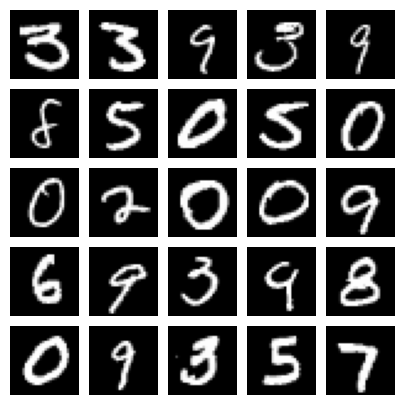

In [3]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [4]:
# The input dimension is 784 which is the flattened dimension of MNIST images (28×28)
#  In the encoder, the mean (μ) and variance (σ²) vectors are our variational representation vectors (size=200). 
# Notice that we multiply the latent variance with the epsilon (ε) parameter
# for reparameterization before decoding. This allows us to perform backpropagation and tackle the node stochasticity. 
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(self.__init__())

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2)
        )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim,
            nn.Sigmoid())
        )

        # Functions of the VAE
        def encoder(self, x):
            x = self.encoder(x)
            mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        
        def reparameterize(self, mean, var):
            epsilon = torch.randn_like(var).to(device)      
            z = mean + var*epsilon
            return z
        
        def decode(self, z):
            return self.decoder(z)
        
        def forward(self, x):
            mean, logvar = self.encoder(x)
            z = self.reparameterization(mean, logvar)
            x_hat = self.decode(z)
            return x_hat, mean, logvar

In [ ]:
# Add the optimizer
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Create the loss function
def loss(x, x_hat, mean, logvar):
    # reconstruction loss
    reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    # KL divergence loss
    KLD = - 0.5 * torch.sum(1+ logvar - mean.pow(2) - logvar.exp())

    return reconstruction_loss + KLD

In [ ]:
# Train the model
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)
            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

train(model, optimizer, epochs=10, device=device)

In [ ]:
# Function to generate digits from the latent space
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

# Generate the digits
generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)


In [ ]:
# Function to explore and plot the latent space (good example for shape embed)
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)